In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy


In [2]:
data_2022 = pd.read_csv('../data/img_scout_dfs/2022/smr_vis_skysat_scout_2022.csv')

In [3]:
data_2022.Date.unique()

array(['2022-06-22', '2022-07-06', '2022-07-20'], dtype=object)

In [4]:
data_2022['DMCast_events'] = 0
data_2022.loc[data_2022['Date'] == '2022-06-22', 'DMCast_events'] = 9
data_2022.loc[data_2022['Date'] == '2022-07-06', 'DMCast_events'] = 24
data_2022.loc[data_2022['Date'] == '2022-07-20', 'DMCast_events'] = 25

In [5]:
data_2022['GDM_sev']='low'
data_2022.loc[data_2022['DM_severity'] > 10, 'GDM_sev'] = 'high'
    
data_2022['GDM_inc']='low'
data_2022.loc[data_2022['DM_inc'] > 25, 'GDM_inc'] = 'high'

Low severity: 710
High severity: 10
Proportion: 71.0 : 1


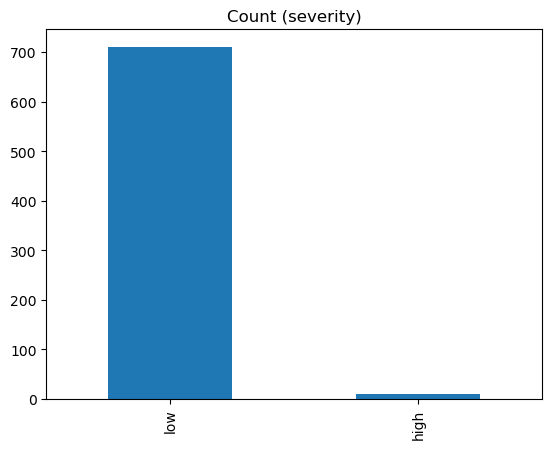

In [6]:
target_count = data_2022.GDM_sev.value_counts()
print('Low severity:', target_count[0])
print('High severity:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (severity)');

In [7]:
# All high severity panels are clustered on later image dates
# leaving one of these images out will make test set too small

# Better idea: random forest for 2020, report accuracy metrics and kappa score

# Later test global model on hold-out image from 2020

data_2022[data_2022['GDM_sev']=='high'].Date.unique()

array(['2022-07-06', '2022-07-20'], dtype=object)

In [8]:
data_2022.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'green_red', 'green_blue', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'DM_inc', 'PM_inc', 'DMCast_events', 'GDM_sev',
       'GDM_inc'],
      dtype='object')

In [9]:
# First with no DMCast
expl_vars = ['blue', 'green', 'red', 'nir','savi', 'evi', 'arvi', 'gri', 'ndvi']
resp_var = 'GDM_sev'

In [10]:
def run_rf_us(df, expl_vars, resp_var, SPLIT_RND_SEED, rand_state):
    X = df[expl_vars]
    y = df[resp_var]
    
    rus = RandomUnderSampler(random_state=2020)
    X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

    X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test
    from sklearn.ensemble import RandomForestClassifier
    # Create a Gaussian Classifier with 500 trees 
    rf = RandomForestClassifier(n_estimators = 500, 
                                oob_score=True, 
                                random_state=rand_state, # random number to be used, needed to reproduce the same result
                                verbose=False)
    
    rf_model = rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    
    from sklearn.metrics import precision_recall_fscore_support
    
    prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
  
    
    from sklearn.metrics import cohen_kappa_score
        
    cohen_score = cohen_kappa_score(y_test, y_pred)    

    
    metrics = {
        'cohen_kappa': [cohen_score], 
        'accuracy_score': [accuracy],
        'precision': [prec],
        'recall': [recall]
    }
    metrics_df = pd.DataFrame(data=metrics)
    
    return metrics_df


In [11]:
import random
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [13]:
results = []
for r in rand_list:
    res_df = run_rf_us(data_2022, expl_vars, resp_var, r, 2022)
    
    results.append(res_df)

/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kathleenkanaley/miniconda3/envs/planetenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [14]:
results_df = pd.concat(results)

results_df.mean()

cohen_kappa      -0.123333
accuracy_score    0.438333
precision         0.386500
recall            0.438333
dtype: float64

In [15]:
# For incidence
 
rand_list=[]
n=100
for i in range(n):
    rand_list.append(random.randint(100,999))

In [16]:
results_inc = []
for r in rand_list:
    res_df = run_rf_us(data_2022, expl_vars, 'GDM_inc', r, 3030)
    
    results_inc.append(res_df)

In [17]:
results_inc_df = pd.concat(results_inc)

results_inc_df.mean()

cohen_kappa       0.130000
accuracy_score    0.565000
precision         0.569621
recall            0.565000
dtype: float64